In [1]:
import os
import pickle
import itertools
import pandas as pd
import numpy as np
#from modelgym import model
import functools
import modelgym
from modelgym.util import TASK_CLASSIFICATION
from modelgym.trainer import Trainer
from modelgym.tracker import ProgressTrackerFile, ProgressTrackerMongo
from sklearn.metrics import roc_auc_score
from hyperopt.mongoexp import MongoTrials
from modelgym.util import split_and_preprocess
from sklearn.model_selection import train_test_split
from collections import OrderedDict

/opt/conda/envs/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
########### NROWS, N_ESTIMATORS, N_PROBES, TEST_SIZE, N_CV_SPLITS, OPTIMIZER
config_tuple = {
    'test': (1000, 100,  2, 0.5, 2, 'random'),
    'pror': (None, 1000, 100, 0.5, 2, 'random'), # production with random hyperopt suggestor
    'prot': (None, 1000, 100, 0.5, 2, 'tpe'),    # production with tpe hyperopt suggestor
    'demi': (10000, 100, 5, 0.5, 2, 'random')
}
CONFIG = 'test' if 'EXP_CONFIG' not in os.environ else os.environ['EXP_CONFIG']
NROWS, N_ESTIMATORS, N_PROBES, TEST_SIZE, N_CV_SPLITS, OPTIMIZER = config_tuple[CONFIG]
CANDIDATES = OrderedDict([
    ('XGBoost', modelgym.XGBModel), 
    ('LightGBM', modelgym.LGBModel),
    ('RandomForestClassifier',modelgym.RFModel)
])
RESULTS_DIR = "results"
LOAD_CACHE = False
if 'MONGO_PORT_27017_TCP_ADDR' in os.environ:
    mongo_host = os.environ['MONGO_PORT_27017_TCP_ADDR'] if 'MONGO_PORT_27017_TCP_ADDR' in os.environ else 'cern-mc01h'
    mongo_port = int(os.environ['MONGO_PORT_27017_TCP_PORT']) if 'MONGO_PORT_27017_TCP_PORT' in os.environ else 27017
    mongo_db = os.environ['MONGO_DB'] if 'MONGO_DB' in os.environ else 'trials'
    tracker_factory = functools.partial(ProgressTrackerMongo, mongo_host, mongo_port, mongo_db, config_key=CONFIG)
    print ("Using Mongo as backend for tracking")
else:
    tracker_factory = functools.partial(ProgressTrackerFile, RESULTS_DIR, config_key=CONFIG)
    print ("Using File as backend for tracking")

print ("Running experiment cofiguration:", CONFIG)

Using File as backend for tracking
Running experiment cofiguration: test


## Download & read data file

In [3]:
%%bash 
if [ ! -d data ] ; then 
    mkdir data 
    cd data
    curl https://cernbox.cern.ch/index.php/s/N1dpSAPgl30szYM/download | gunzip -c > XY2d.pickle
    cd ..
fi
ls -l data

total 133112
-rw-r--r-- 1 1000 staff 136304022 Dec 10 13:40 XY2d.pickle


In [4]:
def read_data(fname, nrows=None, shuffle=True):
    with open(fname,'rb') as fh:
        X, y = pickle.load(fh,encoding='bytes')
    index = np.arange(X.shape[0])
    if nrows is None:
        nrows = X.shape[0]
    weights = np.ones(nrows) # uh, well...
    if shuffle:
        index_perm = np.random.permutation(index)
    else:
        index_perm = index
    return X[index_perm[:nrows]], y[index_perm[:nrows]], weights


X, y, weights = read_data("data/XY2d.pickle", nrows=NROWS)

In [5]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=TEST_SIZE)

In [6]:
cv_pairs, (dtrain, dtest) = split_and_preprocess(X_train.copy(), y_train, 
                                                X_test.copy(), y_test, 
                                                cat_cols=[], n_splits=N_CV_SPLITS)

## Run them all

In [7]:
def init_keys_dict():
    return dict(
        [(k, {'default_cv': None, 'tuned_cv': None, 'default_test': None, 'tuned_test': None, 'trials': None}) for k in
         CANDIDATES.keys()])


trackers = {}
custom_metric = {'roc_auc': roc_auc_score}
all_metrics = init_keys_dict()
trainer = Trainer(opt_evals=N_PROBES, n_estimators=N_ESTIMATORS)

In [8]:
def gym_training(trainer, model, all_metrics, trackers, cv_pairs, dtrain, dtest, mode):
    name = model.get_name()
    metrics = all_metrics[name]
    tracker = trackers[name]
    cv_key = mode + "_cv"
    test_key = mode + "_test"
    if metrics[cv_key] is None:
        if mode == "default":
            metrics[cv_key] = trainer.crossval_fit_eval(model, cv_pairs)
        elif mode == "tuned":
            print('Hyperopt iterations:\n\n')
            metrics[cv_key] = trainer.crossval_optimize_params(model, cv_pairs, algo_name=OPTIMIZER,
                                                               trials=metrics['trials'],
                                                               tracker=tracker)
        else:
            raise ValueError("{0} not expected".format(mode))
        tracker._update_state(metrics)
    trainer.print_result(metrics[cv_key], '{0} {1} result on CV'.format(mode, name))

    if metrics[test_key] is None:
        metrics[test_key] = trainer.fit_eval(model, dtrain, dtest,
                                             metrics[cv_key]['params'],
                                             metrics[cv_key]['best_n_estimators'],
                                             custom_metric=custom_metric)
        tracker._update_state(metrics)
    trainer.print_result(metrics[test_key], '{0} {1} result on TEST'.format(mode, name), extra_keys=['roc_auc'])

In [9]:
for model_class in CANDIDATES.values():
    model = model_class(TASK_CLASSIFICATION)
    name = model.get_name()
    print("~" * 20, name, "~" * 20)
    trackers[name] = tracker_factory(model_name=name)
    if LOAD_CACHE:
        all_metrics[name] = trackers[name].load_state()

    gym_training(trainer, model, all_metrics, trackers, cv_pairs, dtrain, dtest, 'default')
    gym_training(trainer, model, all_metrics, trackers, cv_pairs, dtrain, dtest, 'tuned')

    trackers[name].save_state()

~~~~~~~~~~~~~~~~~~~~ XGBoost ~~~~~~~~~~~~~~~~~~~~
default XGBoost result on CV:

loss = 0.39979334
best_n_estimators = 2
params = {'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 1, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'silent': 1}
default XGBoost result on TEST:

loss = 0.611043
n_estimators = 2
params = {'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 1, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'silent': 1}
roc_auc = 0.647908
Hyperopt iterations:


[1/2]	eval_time=0

## Compare

In [10]:
metric, mes_min = 'roc_auc', False
full_results = {}
for i in CANDIDATES.keys():
    if i in trackers:
        tracker = trackers[i]
    else:
        tracker = tracker_factory(model_name=i)
        tracker.load_state()
    full_results.update({i:{'tuned': tracker.state['tuned_test'], 'default': tracker.state['default_test']}})
#print(full_results)

In [11]:
def plot_metric_results(full_results, index, metric, is_min_better=True):
    test_results_list = []
    for i in index:
        test_results_list.append([full_results[i]['default'][metric], full_results[i]['tuned'][metric]])
        
    test_results = np.array(test_results_list)
    if is_min_better:
        baseline = test_results.min()
    else:
        baseline = test_results.max()
    diff = 100 * test_results / baseline - 100
    test_results_formatted = [['{:.6f} ({:+.2f}%)'.format(test_results[i, j], diff[i, j]) for j in range(2)] for i in range(len(index))]

    print (pd.DataFrame(test_results_formatted, columns=['default', 'tuned'], index=index))
    
    full_names = [" ".join(i) for i in itertools.product(index, ['default', 'tuned'])]

    named_results = zip(full_names, test_results.flatten())

    sorted_results = sorted(named_results, key=lambda x: x[1], reverse=not is_min_better)
    xticks = ['%s\n%.5f' % (name, loss) for name, loss in sorted_results]

    pyplot.figure(figsize=(20, 7))
    pyplot.scatter(range(len(full_names)), list(zip(*sorted_results))[1], s=150)
    pyplot.xticks(range(len(full_names)), xticks, fontsize=15)
    pyplot.yticks(fontsize=12)
    pyplot.title('Comparison', fontsize=20)
    pyplot.ylabel(metric, fontsize=16)

Populating the interactive namespace from numpy and matplotlib
                                   default               tuned
XGBoost                  0.647908 (-0.59%)   0.642955 (-1.35%)
LightGBM                 0.647755 (-0.61%)   0.651721 (+0.00%)
RandomForestClassifier  0.500000 (-23.28%)  0.561924 (-13.78%)


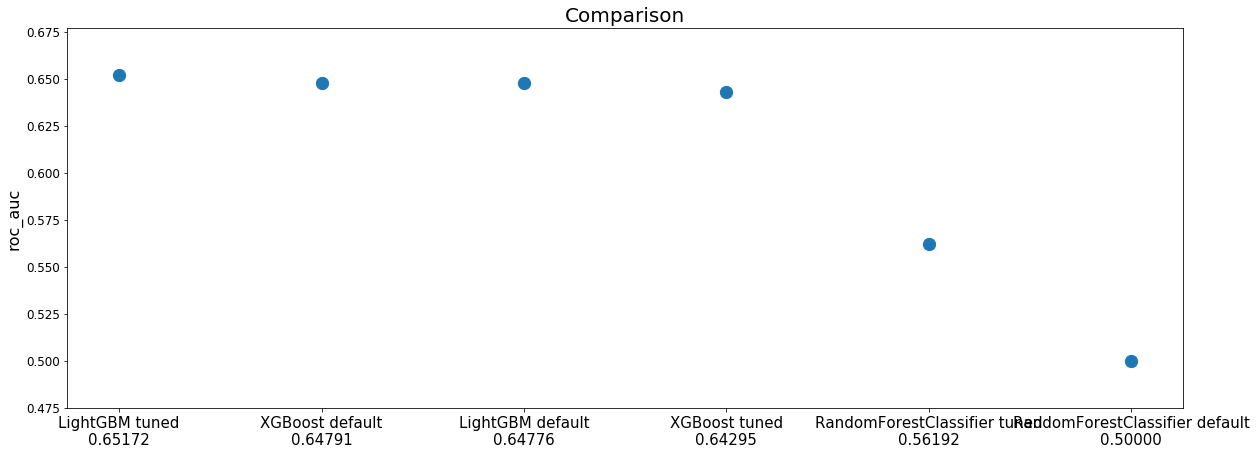

In [12]:
%pylab inline --no-import-all
metric, is_min_better = 'roc_auc', False
plot_metric_results(full_results, CANDIDATES.keys(), metric, is_min_better=is_min_better)

# Compare models with stat test

## Compare that out tuned RF model is statistically better than default

In [13]:
from sklearn.ensemble import RandomForestClassifier
default_rf_model = RandomForestClassifier()
default_rf_model.fit(dtrain.X, dtrain.y)

tuned_rf_model = full_results['RandomForestClassifier']['tuned']['bst']

print('Two models are different: {}, p-value {}'.format(
    *modelgym.util.compare_models_different(tuned_rf_model, default_rf_model, dtest)
))

Two models are different: True, p-value [[ 0.00590535]]


## Compare default LightGBM and default RF

In [14]:
import lightgbm
default_lightGBM_model = lightgbm.LGBMClassifier()
default_lightGBM_model.fit(dtrain.X, dtrain.y)

print('Two models are different: {}, p-value {}'.format(
    *modelgym.util.compare_models_different(default_lightGBM_model, default_rf_model, dtest)
))

Two models are different: True, p-value [[  5.51045296e-09]]
